# Document Question Answering

Natural PDF includes document QA functionality that allows you to ask natural language questions about your PDFs and get relevant answers. This feature uses LayoutLM models to understand both the text content and the visual layout of your documents.

## Setup

Let's start by loading a sample PDF to experiment with question answering.

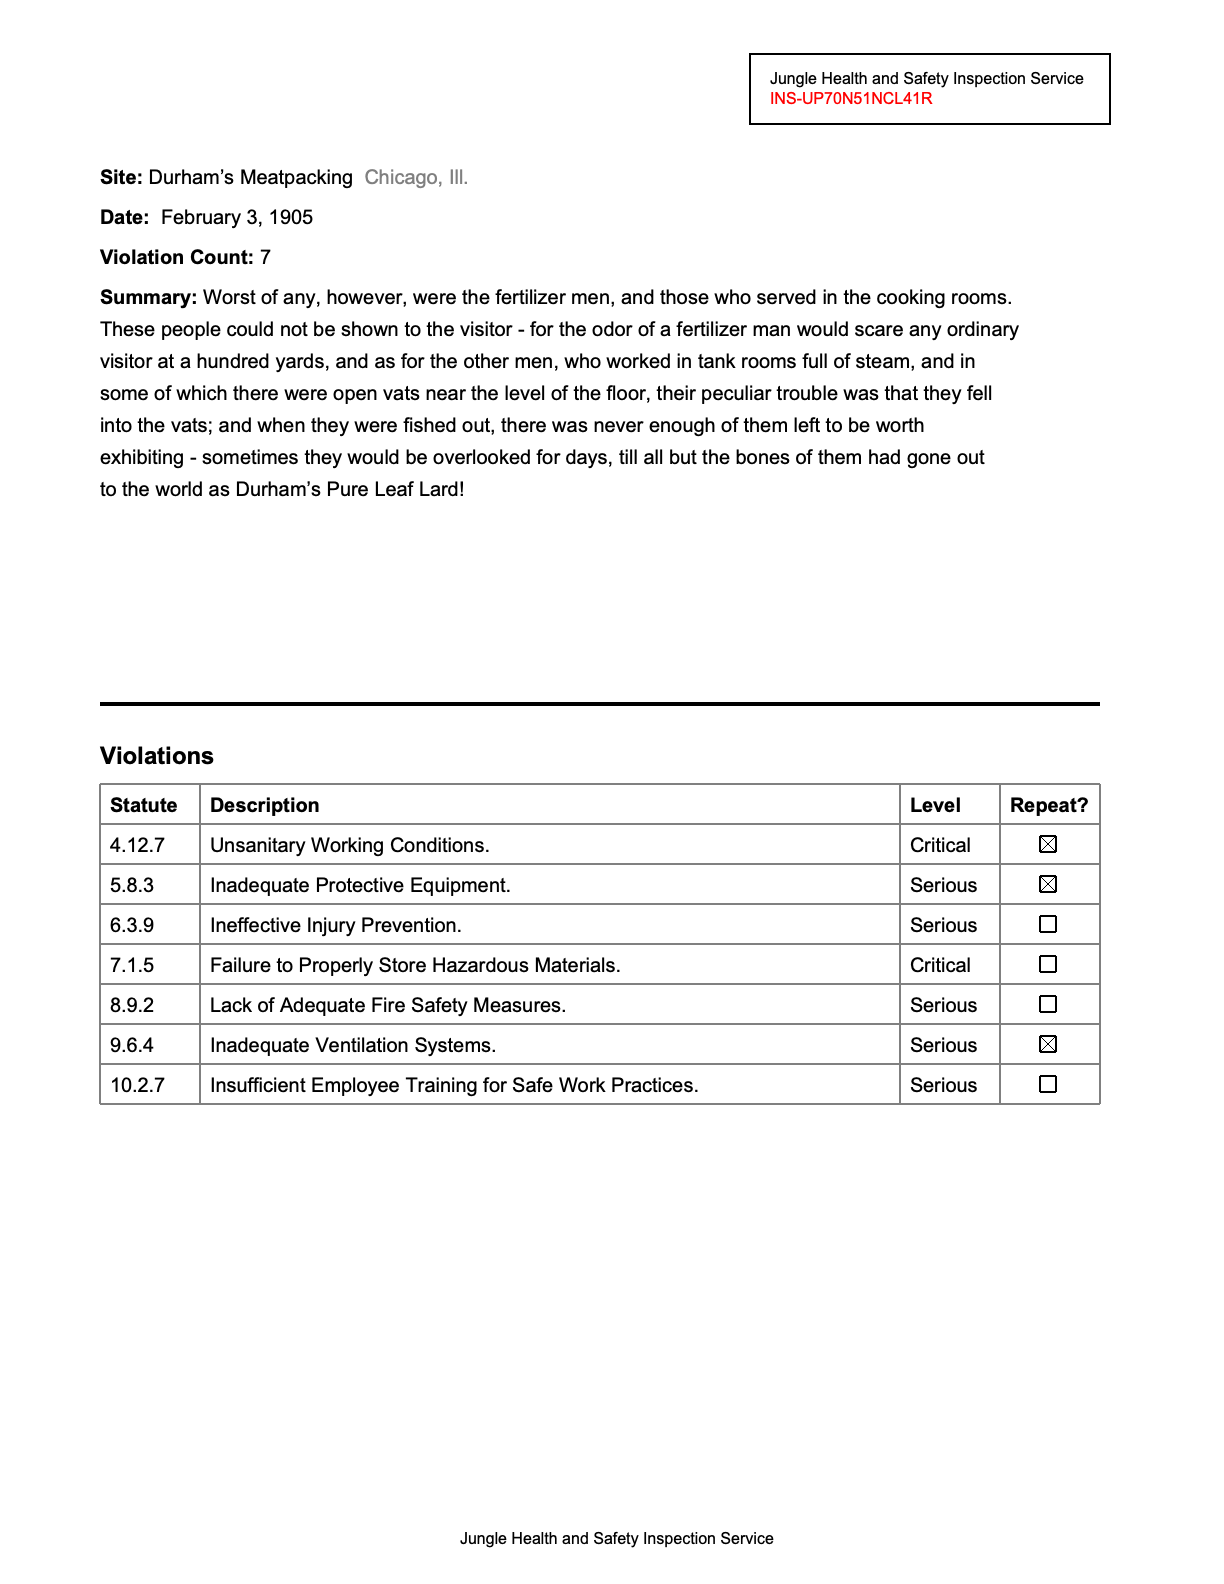

In [1]:
from natural_pdf import PDF

# Path to sample PDF
pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")

# Display the first page 
page = pdf.pages[0]
page.show()

## Basic Usage

Here's how to ask questions to a PDF document:

In [2]:
# Ask a question about the entire document
result = pdf.ask("What is the main topic of this document?")

# Get the answer
if result.get("found", False):
    print(f"Answer: {result['answer']}")
    print(f"Confidence: {result['confidence']:.2f}")
    print(f"Found on page: {result.get('page_num', 0)}")
else:
    print("No answer found.")

Device set to use cpu


Answer: Description
Confidence: 0.45
Found on page: 0


## Asking Questions to Specific Pages

You can also ask questions to a specific page:

In [3]:
# Get a specific page
page = pdf.pages[0]

# Ask a question just about this page
result = page.ask("What information is presented in the table?")

# Get the answer
if result.get("found", False):
    print(f"Answer: {result['answer']}")
    print(f"Confidence: {result['confidence']:.2f}")
    
    # Access the source elements that contain the answer
    if "source_elements" in result:
        # Highlight the answer
        page_copy = page.copy()
        for element in result["source_elements"]:
            page_copy.highlight(element, color="orange", alpha=0.3)
        
        # Show the highlighted page
        page_copy.show()

Answer: Description
Confidence: 0.89


AttributeError: 'Page' object has no attribute 'copy'

## Asking Questions to Regions

You can even ask questions to specific regions of a page:

In [ ]:
# First, find a region of interest
# Let's run layout analysis to find tables
page.analyze_layout(engine="yolo")
table_region = page.find('region[type=table]')

if table_region:
    # Ask a question just about this table region
    result = table_region.ask("What are the numbers in this table?")
    
    # Get the answer
    if result.get("found", False):
        print(f"Answer: {result['answer']}")
        print(f"Confidence: {result['confidence']:.2f}")
        
        # Highlight the region and the answer
        page_copy = page.copy()
        page_copy.highlight(table_region, color="blue", alpha=0.2, label="Table Region")
        
        if "source_elements" in result:
            for element in result["source_elements"]:
                page_copy.highlight(element, color="red", alpha=0.3, label="Answer")
        
        # Show the highlighted page
        page_copy.show()

## Controlling Model and Parameters

You can control which model is used and set various parameters:

In [ ]:
# Specify a different model
result = pdf.ask(
    "What information does this document contain?",
    model="microsoft/layoutlmv3-large"
)

# Set a higher confidence threshold for more reliable answers
result = pdf.ask(
    "What dates are mentioned in the document?", 
    min_confidence=0.8  # Only accept answers with 80%+ confidence
)

# Control image resolution for better accuracy
result = page.ask(
    "What is in the header section?",
    resolution=300  # Higher resolution for better text recognition
)

# Set a maximum length for the answer
result = page.ask(
    "Summarize the content",
    max_answer_length=50  # Keep the answer concise
)

# Specify the language for non-English documents
result = pdf.ask(
    "Quels sont les revenus totaux?",
    language="fr"  # Use French for the question and answer
)

## Handling OCR Documents

Document QA works with both native text PDF documents and scanned documents requiring OCR:

In [ ]:
# For a scanned document, enable OCR
scanned_pdf = PDF('scanned_document.pdf', ocr=True)

# Ask a question - OCR will be automatically applied if needed
result = scanned_pdf.ask("What is the date of the report?")

# You can explicitly control OCR behavior
result = page.ask(
    "Who signed the document?",
    use_ocr=True,  # Force OCR even if there's native text
    ocr_languages=["en"]  # Specify OCR language
)

For best results with scanned documents, you might need to fine-tune OCR settings. See our [OCR Challenges and Solutions](../explanations/ocr-challenges.md) guide for detailed advice on improving OCR quality before applying Document QA.

## Debugging and Troubleshooting

If you're having trouble with document QA, you can enable debugging to see more details:

In [ ]:
# Enable debug mode to save intermediate files
result = page.ask(
    "What is mentioned about implementation?",
    debug=True  # Will save images and word boxes to the output directory
)

This will save:
- The input image
- The extracted word boxes
- A visualization of the word boxes
- The raw result from the model

You can also specify a custom debug directory:

In [ ]:
result = page.ask(
    "What are the recommendations in this document?",
    debug=True,
    debug_dir="qa_debug"  # Save debug files to this directory
)

## Handling Complex Documents

For complex documents, you might want to break them down into focused questions:

In [ ]:
# First find the relevant section
page.analyze_layout()
main_content = page.find('region[type=plain-text]')

if main_content:
    # Then ask specific questions about that section
    topic_result = main_content.ask("What is the main topic?")
    detail_result = main_content.ask("What specific details are provided?")
    conclusion_result = main_content.ask("What is the conclusion?")
    
    # Combine the answers
    if topic_result.get("found") and detail_result.get("found"):
        print(f"Main topic: {topic_result['answer']}")
        print(f"Details: {detail_result['answer']}")
        if conclusion_result.get("found"):
            print(f"Conclusion: {conclusion_result['answer']}")
            
        # Highlight all answers with different colors
        page_copy = page.copy()
        if "source_elements" in topic_result:
            for elem in topic_result["source_elements"]:
                page_copy.highlight(elem, color="red", alpha=0.3, label="Topic")
                
        if "source_elements" in detail_result:
            for elem in detail_result["source_elements"]:
                page_copy.highlight(elem, color="green", alpha=0.3, label="Details")
                
        if "source_elements" in conclusion_result:
            for elem in conclusion_result["source_elements"]:
                page_copy.highlight(elem, color="blue", alpha=0.3, label="Conclusion")
                
        # Show the visualization
        page_copy.show(labels=True)

## Preprocessing Documents for Better Results

For best results, you might want to prepare your documents:

In [ ]:
# Remove headers and footers
pdf.add_exclusion(
    lambda page: page.create_region(0, 0, page.width, 50),
    label="header"
)
pdf.add_exclusion(
    lambda page: page.create_region(0, page.height-50, page.width, page.height),
    label="footer"
)

# Find the main content area and focus questions there
for i, page in enumerate(pdf.pages):
    # Apply layout analysis to find the main content
    page.analyze_layout()
    
    # Get text regions
    text_regions = page.find_all('region[type=plain-text]')
    
    # Ask questions about the main content
    for region in text_regions:
        result = region.ask("What is the main topic discussed?")
        if result.get("found", False) and result.get("confidence", 0) > 0.7:
            print(f"Page {page.page_number}, Topic: {result['answer']}")
            
    # Only process the first few pages in this example
    if i >= 2:
        break

## Complete Document QA Example

Here's a complete example that walks through the document QA process:

In [ ]:
from natural_pdf import PDF
import os

# Create output directory if it doesn't exist
os.makedirs("qa_results", exist_ok=True)

# Open a PDF
pdf_path = Path("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")
pdf = PDF(pdf_path)

# First, ask a general question to the entire document
general_result = pdf.ask("What type of document is this?")
if general_result.get("found", False):
    print(f"Document type: {general_result['answer']}")
    print(f"Found on page {general_result.get('page_num', 0)}")
    
    # Get the page where the answer was found
    if 'page_num' in general_result:
        relevant_page = pdf.pages[general_result['page_num'] - 1]  # Convert to 0-indexed
        
        # Analyze layout on this page
        relevant_page.analyze_layout()
        
        # Find regions of interest
        regions = relevant_page.find_all('region')
        
        # Ask specific questions about each region
        for i, region in enumerate(regions):
            region_result = region.ask("What information does this section provide?")
            if region_result.get("found", False):
                print(f"Region {i+1}: {region_result['answer']}")
                
                # Save a visualization
                img = relevant_page.copy()
                img.highlight(region, color="blue", alpha=0.2, label=f"Region {i+1}")
                if "source_elements" in region_result:
                    for elem in region_result["source_elements"]:
                        img.highlight(elem, color="red", alpha=0.3)
                img.save_image(f"qa_results/region_{i+1}_answer.png")
else:
    print("Could not determine document type.")

print("Analysis complete. Results saved to 'qa_results' directory.")

## Next Steps

Now that you've learned about document QA, explore:

- [Element Selection](../element-selection/index.md): Find specific elements to focus your questions.
- [Layout Analysis](../layout-analysis/index.md): Automatically detect document structure.
- [Working with Regions](../regions/index.md): Define custom areas for targeted questioning.
- [Text Extraction](../text-extraction/index.md): Extract and preprocess text before QA.